Copyright (C) rflylab from School of Automation Science and Electrical Engineering, Beihang University.

All Rights Reserved.

This example shows how to assess the health status of the propulsors of the multicopters by the loss factor.
The loss factor is a coefficent indicating how much force a propeller can generate.
It can be esitimated by some filter such as kalman filter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

from OpenHA.assessment.attribute import degree_of_controllablity as DOC

In [3]:
# load the data from the local csv file
# the names of the columns are
# timestamp,euler_re_roll,euler_re_pitch,euler_re_yaw,omega_re_p,omega_re_q,omega_re_r,sigma_re,,,,z_re,vz_re,dot_euler_re,,,eta_1,,,eta_4,doc

data = pd.read_csv('log_7_2022-5-12-16-22-12_lossfactor.csv', header=0)

In [4]:
# data from the csv file
# timestamp
timestamp = data.values[:, 0] / 1e6
# euler angle
euler = data.values[:, 1:4].T
# angular spped
omega = data.values[:, 4:7].T
# throttle
sigma = data.values[:, 7:11].T
# height and velocity
z = data.values[:, 11]
vz = data.values[:, 12]
# euler angular acceleration
dot_euler = data.values[:, 13:16].T

In [5]:
# arguments of the phycial parameters
# number of propeller
n_p = 4
# mass and moment of inertia
ma = 1.4
g = 9.8
Jx = 0.0211
Jy = 0.0219
Jz = 0.0366
J = np.diag([-1 / ma, 1 / Jx, 1 / Jy, 1 / Jz])
# calculate the force by throttle
Cb = 1148 / 12.6
Ub = 12.6
omega_b = -141.4
ct = 1.105e-05
f = ct * (Cb * Ub * sigma + omega_b) ** 2
# maximun value of the force of each propeller
fmax = ct * (Cb * Ub * 1 + omega_b) ** 2

In [7]:
# control allocation matrix
d = 0.225
cm_ct = 0.0161
# pay attention to the number and rotate direction of each propeller
Bf = DOC.control_allocation(
    n_p,
    d,
    cm_ct,
    init_angle=np.array([45, 225, 315, 135]) * np.pi / 180,
    drct=[1, 1, -1, -1],
)
Bf = np.matrix(Bf)
# maximun value of the ACAI
acai_max = DOC.acai(Bf, fmax, 0, np.array([[ma * g, 0, 0, 0]]).T)

In [10]:
# sample time
ts = 0.05
# matrix of the state equation
B = np.concatenate(
    (np.eye(4) * ts**2 / 2, np.eye(4) * ts, np.zeros((n_p, 4))), axis=0
)
B = np.matmul(B, J)
C = np.concatenate((np.eye(8), np.zeros((8, n_p))), axis=1)
C = np.matrix(C)


In [8]:
# initialize
P = np.eye(12) * 0.1
X = np.zeros((12, 1))
I = np.eye(8 + n_p)

p_var = 0.005
Q = np.eye(12) * p_var**2

m_var = 1
R = np.eye(8) * m_var**2

# used to save the final result
length = timestamp.shape[0]
eta = np.zeros((n_p, length))
doc = np.zeros((length,))

In [11]:
# algorithm of the kalman filter
for i in range(length):
    # shows the process
    print('\r', 'Step: %04d/%d' % (i, length), end='', flush=True)
    #
    Gamma_f = np.diag(f[:, (i,)].reshape((n_p)))
    M = -np.matmul(np.matmul(J, Bf), Gamma_f)
    A1 = np.concatenate((np.eye(4), np.eye(4) * ts, M * ts**2 / 2), axis=1)
    A2 = np.concatenate((np.zeros((4, 4)), np.eye(4), M * ts), axis=1)
    A3 = np.concatenate((np.zeros((n_p, 8)), np.eye(n_p)), axis=1)
    A = np.matrix(np.concatenate((A1, A2, A3), axis=0))

    X_pre = A * X + B * (Bf * f[:, (i,)] - np.array([[ma * g, 0, 0, 0]]).T)
    P_pre = A * P * A.T + Q
    K = P_pre * C.T * sp.linalg.inv(C * P_pre * C.T + R)

    Z_k = np.concatenate(
        (np.array([[z[i]]]), euler[:, (i,)], np.array([[vz[i]]]), omega[:, (i,)]),
        axis=0,
    )
    X = X_pre + K * (Z_k - C * X_pre)
    P = (I - K * C) * P_pre
    # 保存结果
    eta[:, (i,)] = X[8:12, 0]
    doc[i] = (
        DOC.acai(
            Bf,
            fmax * (np.ones((4, 1)) - eta[:, (i,)]),
            0,
            np.array([[ma * g, 0, 0, 0]]).T,
        )
        / acai_max
    )



 Step: 4010/4011Step: 0421/4011Step: 1984/4011Step: 2769/4011

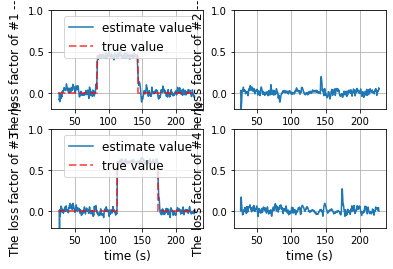

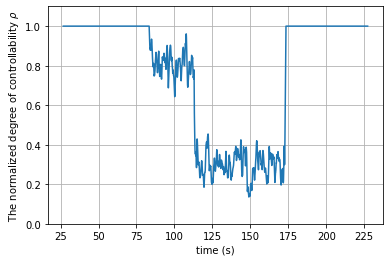

In [12]:
# plot
# time of the true value of the loss factor
t1 = [25, 83, 83, 143, 143, 230]
y1 = [0, 0, 0.45, 0.45, 0, 0]
t2 = [25, 113, 113, 173, 173, 230]
y2 = [0, 0, 0.6, 0.6, 0, 0]

fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        ax[i][j].plot(timestamp, eta[i * 2 + j])
        ax[i][j].set_ylabel(
            f'The loss factor of #{i*2+j+1} -- $\eta_{i*2+j+1}$', fontsize=12
        )
        ax[i][j].set_ylim(-0.2, 1)
        ax[i][j].grid()
        ax[i][j].set_xlabel('time (s)', fontsize=12)
# plot of the true value
ax[0][0].plot(t1, y1, ls='--', color='r', lw=2, alpha=0.6)
ax[0][0].legend(['estimate value', 'true value'], fontsize=12)
ax[1][0].plot(t2, y2, ls='--', color='r', lw=2, alpha=0.6)
ax[1][0].legend(['estimate value', 'true value'], fontsize=12)

plt.show()

# plot the doc
fig, ax = plt.subplots()
ax.clear()
ax.plot(timestamp, doc)
ax.set_ylim((0, 1.1))
ax.grid()
ax.set_xlabel('time (s)')
ax.set_ylabel(r'The normalized degree of controllability $\rho$')
plt.show()
